In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alanjacob03","key":"1b8ab587f0d6b7e7e08650d6e6708308"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d farzadnekouei/pothole-image-segmentation-dataset

 92% 49.0M/53.5M [00:00<00:00, 88.0MB/s]
100% 53.5M/53.5M [00:00<00:00, 81.7MB/s]


In [ ]:
! mkdir Data

In [ ]:
! unzip -q pothole-image-segmentation-dataset.zip -d Data

In [ ]:
! mkdir '/content/Data/Pothole_Segmentation_YOLOv8/train/masks'

In [ ]:
! mkdir '/content/Data/Pothole_Segmentation_YOLOv8/valid/masks'

In [ ]:
import numpy as np
import pandas as pd
import os
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet101
import matplotlib.pyplot as plt
import shutil
import random
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
import cv2
from google.colab.patches import cv2_imshow
import tensorflow as tf

In [ ]:
source_img_path = r'/content/Data/Pothole_Segmentation_YOLOv8/train/images'
source_label_path = r'/content/Data/Pothole_Segmentation_YOLOv8/train/labels'
source_mask_path = r'/content/Data/Pothole_Segmentation_YOLOv8/train/masks'

## **Visualizing and preprocessing the data**

In [ ]:
print(f"There are {len(os.listdir(source_img_path))} images of potholes.")
print(f"There are {len(os.listdir(source_label_path))} images of labels.")

There are 720 images of potholes.
There are 720 images of labels.


In [ ]:
len(os.listdir('/content/Data/Pothole_Segmentation_YOLOv8/train/images'))

720

## **Generating the masks from the labels**

In [ ]:
def maskGenerator(directory):
  img_dir = directory+'/images/'
  label_dir = directory+'/labels/'

  img_list = os.listdir(img_dir)
  label_list = os.listdir(label_dir)

  for i in range(len(img_list)):
    img_name = img_list[i]
    label_name = '.'.join(img_name.split('.')[:-1]) + '.txt'
    if label_name not in label_list:
      print(label_name)
      pass

    img = cv2.imread(img_dir + img_name)
    label = label_dir + label_name
    img_shape = img.shape
    mask = np.zeros(img_shape)

    file1 = open(label, 'r')
    while True:
      poly = file1.readline()
      if not poly:
        break
      s = poly.split()
      #only single class of segmentation so we dont care about classes
      coord = np.array(s[1:], dtype='float32').reshape(-1,2)
      coord[:,0] = coord[:,0]*np.array(img_shape[0])
      coord[:,1] = coord[:,1]*img_shape[1]
      coord = coord.astype('int32')

      cv2.fillPoly(mask, pts = [coord], color =(255,255,255))
    cv2.imwrite(directory+'/masks/'+img_list[i], mask)




In [ ]:
maskGenerator('/content/Data/Pothole_Segmentation_YOLOv8/train')

In [ ]:
maskGenerator('/content/Data/Pothole_Segmentation_YOLOv8/valid')

## **Contd**

In [ ]:
l_img = os.listdir(source_img_path)
l_mask = os.listdir(source_mask_path)

l_img[0]

'pic-5-_jpg.rf.f3d79095cd22dd76dc99c447f82e50d0.jpg'

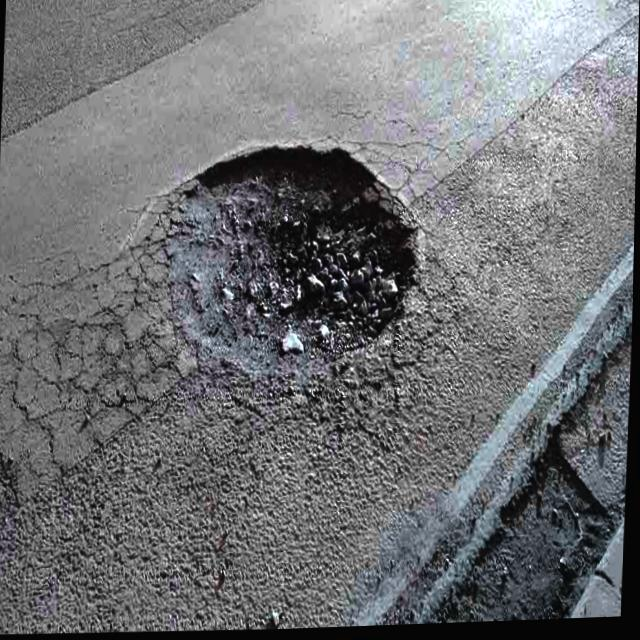

In [ ]:
x = 6
img_pot = cv2.cvtColor(cv2.imread(source_img_path+'/'+l_img[x]),cv2.COLOR_BGR2RGB)
mask_pot = cv2.cvtColor(cv2.imread(source_mask_path+'/'+l_mask[x]),cv2.COLOR_BGR2GRAY)

cv2_imshow(img_pot)

In [ ]:
def apply_mask(img_pot, mask_pot):
  img = img_pot
  img[:,:,2] = cv2.bitwise_or(img_pot[:,:,2], mask_pot)
  return img

Creating the pairs of images which can be passed into a **DataGenerator**

In [ ]:
def make_pair(IMG_DIR,MASK_DIR=''):
  img_list = os.listdir(IMG_DIR)
  pairs = []
  if MASK_DIR!='':
    mask_list = os.listdir(MASK_DIR)

    for i in range(len(img_list)):
      img = IMG_DIR+img_list[i]
      mask = MASK_DIR+mask_list[i]
      pairs.append((img,mask))
  else:
    for i in range(len(img_list)):
      img = IMG_DIR+img_list[i]
      pairs.append((img,''))

  return pairs

In [ ]:
POT_TRAIN_DIR = r'/content/Data/Pothole_Segmentation_YOLOv8/train/images/'
MASK_TRAIN_DIR = r'/content/Data/Pothole_Segmentation_YOLOv8/train/masks/'
len(os.listdir(MASK_TRAIN_DIR))

720

In [ ]:
pair1 = make_pair(POT_TRAIN_DIR, MASK_TRAIN_DIR)
random.shuffle(pair1)

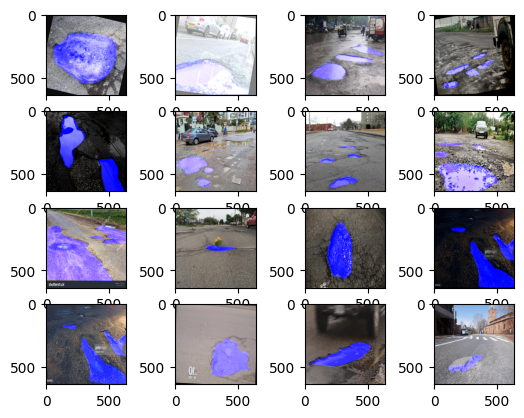

In [ ]:
for i in range(16):
  i1 = cv2.cvtColor(cv2.imread(pair1[i][0]), cv2.COLOR_BGR2RGB)
  i2 = cv2.cvtColor(cv2.imread(pair1[i][1]), cv2.COLOR_BGR2GRAY)
  plt.subplot(4,4,i+1)
  plt.imshow(apply_mask(i1,i2))

Creating the Data Generator

In [ ]:
class DataGenerator(keras.utils.Sequence):
  def __init__(self, pair, batch_size=16, dim=(224,224,3), shuffle=True):
    self.dim = dim
    self.pair = pair
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.on_epoch_end()

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.pair))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __len__(self):
    return int(np.floor(len(self.pair) / self.batch_size))

  def generate_data(self, img_pos):
    img_batch = list()
    mask_batch = list()

    for i in img_pos:
      img = cv2.cvtColor(cv2.imread(self.pair[i][0]),cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, (self.dim[0],self.dim[1]))
      if self.pair[i][1]!='':
        mask = cv2.cvtColor(cv2.imread(self.pair[i][1]),cv2.COLOR_BGR2GRAY)
      else:
        mask = np.zeros(img.shape[:-1])
      mask = cv2.resize(mask, (self.dim[0],self.dim[1]))
      img = img.astype('float32')/255.0
      mask = mask.astype('float32')/255.0
      img_batch.append(img)
      mask_batch.append(mask)

    return np.array(img_batch), np.array(mask_batch)

  def __getitem__(self, index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    img_pos = [i for i in indexes]
    X, y = self.generate_data(img_pos)
    return X, y

In [ ]:
split = 0.8
split_size = int(len(pair1)*split)
train_pairs = pair1[:split_size]
test_pairs = pair1[split_size:]

In [ ]:
len(train_pairs[0])

2

In [ ]:
train_generator = DataGenerator(pair = train_pairs, batch_size=16, dim=(256,256,3), shuffle=True)
train_generator.__len__()

36

In [ ]:
img_pos = np.arange(16).tolist()
random.shuffle(img_pos)
b = train_generator.generate_data(img_pos=img_pos)
len(b)

2

In [ ]:
b[1][10].dtype

dtype('float32')

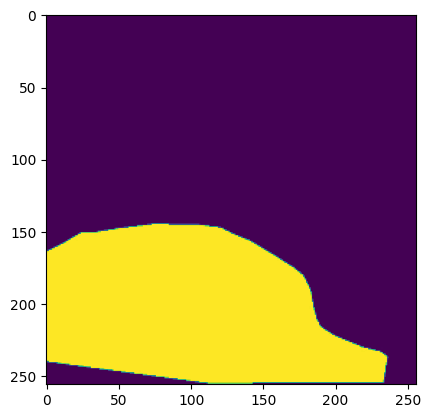

In [ ]:
plt.imshow(b[1][2])

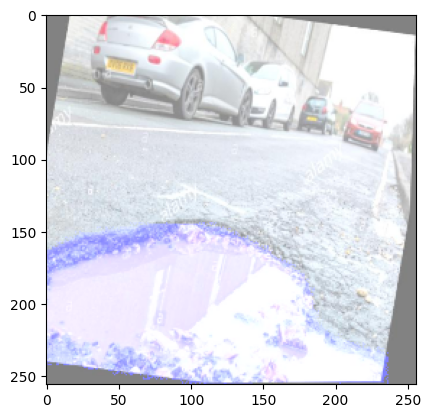

In [ ]:
plt.imshow(apply_mask(b[0][2],b[1][2]))

In [ ]:
test_generator = DataGenerator(pair = test_pairs, dim=(256,256,3), shuffle=True)
test_generator.__len__()

9

# **IMAGE SEGMENTATION USING U-NETS**

## **Basic Architecture of a U-Net**

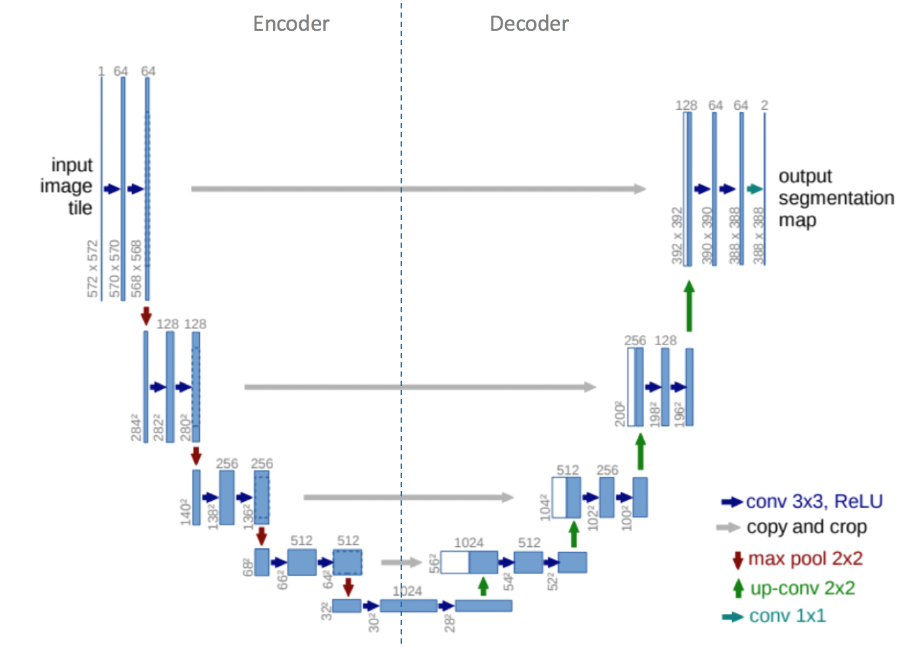

## **Architecture explained**
The U-Net consists of three parts - the encoder, the bottleneck and the decoder
*   The encoder uses downsampling blocks which generates an encoding
*   The decoder uses upsampling blocks which uses Transpose Convolution layers to generate the segmentation mapping from the encoding
*   The bottleneck connects the encoder and the decoder blocks
*   Skip connections are present between the corresponding convolution and transpose-convolution layers



## **Defining the components of the U-Net model**
We make use of the Functional API for this

In [ ]:
def doubleconv_block(x, n_filters):
  x = tf.keras.layers.Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer = 'he_normal')(x)
  x = tf.keras.layers.Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer = 'he_normal')(x)
  return x

In [ ]:
#defining the upsample blocks
#return the conv blocks too to facilitate the skip connections
def downsample_block(x, n_filters):
  f = doubleconv_block(x, n_filters)
  p = tf.keras.layers.MaxPooling2D()(f)
  p = tf.keras.layers.Dropout(0.1)(p)
  return f, p

In [ ]:
#defining the upsample block for the decoder
#the upsample block also takes the skip connections from the encoder
def upsample_block(x, conv_features, n_filters):
  x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding='same')(x)
  x = tf.keras.layers.Concatenate()([x,conv_features])
  x = tf.keras.layers.Dropout(0.1)(x)
  x = doubleconv_block(x, n_filters)
  return x

# **Constructing the U-Net model**
We make use of the abovementioned functions and Keras Functional API to create our model

In [ ]:
def U_NET(input_shape, depth=3):
  f = []
  p = []
  inputs = tf.keras.layers.Input(shape=input_shape)
  pi = inputs
  filters = 64
  #encoder block
  for i in range(depth):
    filters *= 2
    fi, pi = downsample_block(pi, filters)
    f.append(fi)
    p.append(pi)

  #bottleneck
  bottleneck = doubleconv_block(pi, filters)

  #decoder block
  u = bottleneck
  for i in range(depth):
    filters /= 2
    u = upsample_block(u, f[depth - i - 1], filters)
  #output of the mask alone
  #since we have only one class to segment, one filter is enough
  outputs = tf.keras.layers.Conv2D(2, 1, padding='same')(u)

  unet_model = tf.keras.Model(inputs=inputs, outputs=outputs, name='U-Net')
  return unet_model

In [ ]:
depth = 3
unet_model = U_NET(input_shape=(256,256,3), depth=depth)

In [ ]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 128)        3584      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 128)        147584    ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 128)        0         ['conv2d_1[0][0]']            
 D)                                                                                           

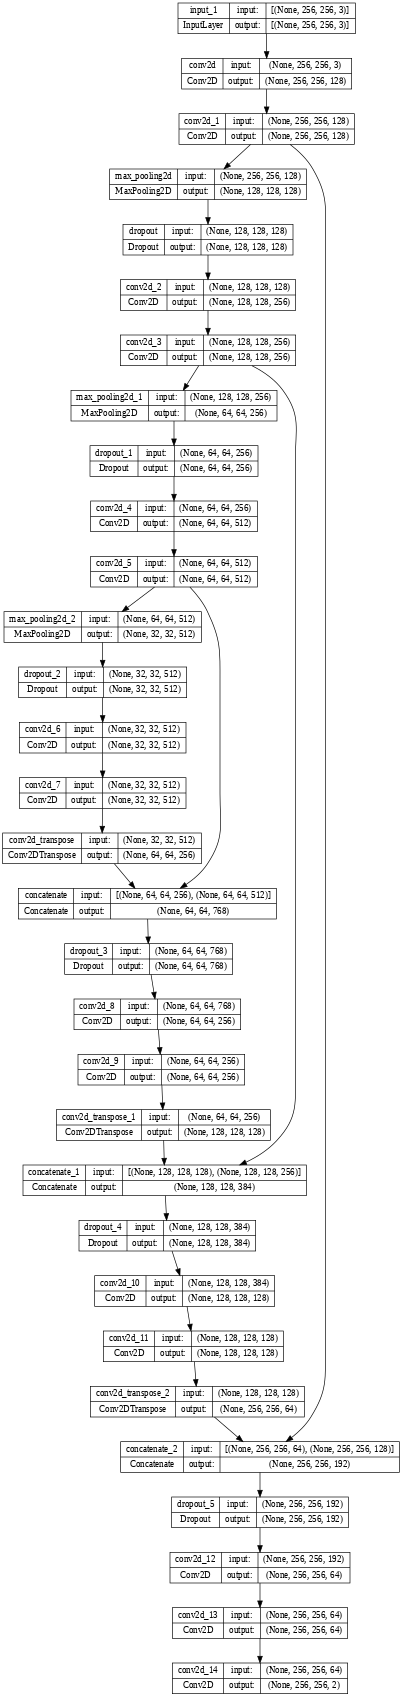

In [ ]:
tf.keras.utils.plot_model(unet_model,
                          to_file='/content/model' + str(depth) + '.png',
                          show_shapes=True,
                          show_dtype=False,
                          show_layer_names=True,
                          rankdir='TB',
                          expand_nested=True,
                          dpi=48,
                          layer_range=None,
                          show_layer_activations=False,
                          show_trainable=False)

The U-Net model is compiled using sparse categorical cross-entropy loss

In [ ]:
#callbacks
earlyStop = keras.callbacks.EarlyStopping(
    monitor="accuracy",
    min_delta=0.005,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=55
)
callbacks = [earlyStop]

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

### **Sample U-Net for depth=4**

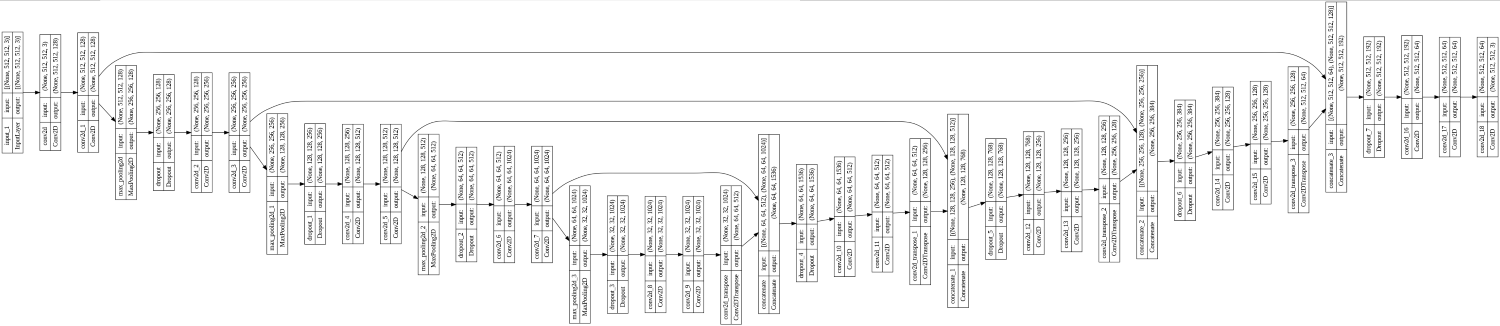

In [ ]:
history = unet_model.fit(train_generator,
                         steps_per_epoch=train_generator.__len__(),
                         epochs=100,
                         validation_data=test_generator,
                         validation_steps=test_generator.__len__(),
                         callbacks=callbacks)

Epoch 1/100
36/36 [==============================] - 102s 1s/step - loss: 0.5146 - accuracy: 0.8000 - val_loss: 0.4540 - val_accuracy: 0.8370
Epoch 2/100
36/36 [==============================] - 53s 1s/step - loss: 0.4564 - accuracy: 0.8327 - val_loss: 0.4322 - val_accuracy: 0.8370
Epoch 3/100
36/36 [==============================] - 53s 1s/step - loss: 0.4322 - accuracy: 0.8327 - val_loss: 0.4192 - val_accuracy: 0.8370
Epoch 4/100
36/36 [==============================] - 55s 2s/step - loss: 0.4142 - accuracy: 0.8327 - val_loss: 0.3821 - val_accuracy: 0.8370
Epoch 5/100
36/36 [==============================] - 54s 1s/step - loss: 0.4021 - accuracy: 0.8328 - val_loss: 0.3749 - val_accuracy: 0.8373
Epoch 6/100
36/36 [==============================] - 53s 1s/step - loss: 0.3903 - accuracy: 0.8343 - val_loss: 0.4114 - val_accuracy: 0.8388
Epoch 7/100
36/36 [==============================] - 53s 1s/step - loss: 0.3863 - accuracy: 0.8339 - val_loss: 0.3658 - val_accuracy: 0.8390
Epoch 8/100


In [ ]:
unet_model.save('/content/my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
files.download('/content/my_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

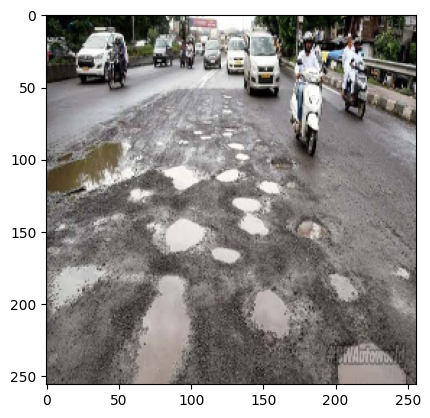

In [ ]:
imgTest = cv2.cvtColor(cv2.imread('/content/pot3.jpg'), cv2.COLOR_BGR2RGB)
imgTest = cv2.resize(imgTest,(256,256)).astype('float32')/255.0
imgTest = np.array([imgTest])
plt.imshow(imgTest[0])

1/1 [==============================] - 0s 30ms/step


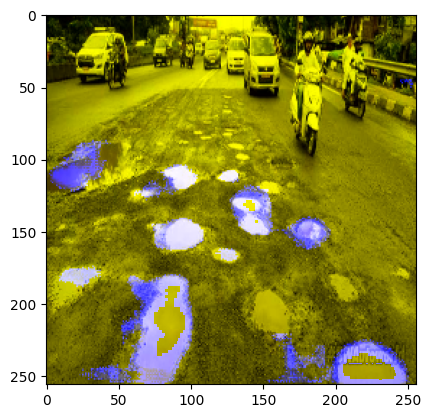

In [ ]:
pred_mask = unet_model.predict(imgTest)
plt.imshow(apply_mask(imgTest[0], pred_mask[0][:,:,1]))